In [31]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras import optimizers
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model


In [32]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [33]:
def NN_discriminator(inputs,kernel_size):
    #kernel_size: length of CNN window
    #input: image
    nfilter_layers=[16,32,64,128]
    x=inputs
    for nfilter in nfilter_layers:
        stride=2
        if nfilter==nfilter_layers[-1]:
            stride=1
        x=LeakyReLU(alpha=0.2)(x)
        x=Conv2D(filters=nfilter,kernel_size=kernel_size,strides=stride,padding='same')(x)
    x=Flatten()(x)
    x=Dense(1)(x)
    x=Activation('sigmoid')(x)
    discriminator=Model(inputs,x,name='Discriminator')
    return discriminator

In [34]:
def NN_generator(inputs,size_imag,kernel_size):
    #nfilter_layers=[64,32,16,1]
    nfilter_layers=[128,64,32,1]
    imag_resize=size_imag//4
    x=Dense(imag_resize*imag_resize*nfilter_layers[0])(inputs)
    x=Reshape((imag_resize,imag_resize,nfilter_layers[0]))(x)
    
    for nfilter in nfilter_layers:
        stride=2
        if nfilter>nfilter_layers[-2]:
            stride=1
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
        x=Conv2DTranspose(filters=nfilter,kernel_size=kernel_size,strides=stride,padding='same')(x)
    x=Activation('sigmoid')(x)
    generator=Model(inputs,x,name='Generator')
    return generator

In [35]:
def plot_imag(generator,noise_input,show=False,step=0,model_name='gan'):
    """
    generator(model)
    noise_input(ndarray): array of latent vector
    """
    os.makedirs(model_name,exist_ok=True)
    filename=os.path.join(model_name,"%3d.png" %step)
    imags=generator.predict(noise_input)
    plt.figure(figsize=(15,15))
    n_imag=imags.shape[0]
    size_imag=imags.shape[1]
    cols=8
    rows=8
    for i in range(64):
        plt.subplot(rows,cols,i+1)
        imag=np.reshape(imags[i],[size_imag,size_imag])
        plt.imshow(imag,cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')
    

In [36]:
def train_GAN(models,x_train,param):
    generator,discrim,gan=models
    batch_size, dim_latent, train_steps = param
    save_interval=1000
    noise=np.random.uniform(-1.0,1.0,size=[64,dim_latent])
    train_size=x_train.shape[0]
    for i in range(train_steps):
        id_rand=np.random.randint(0,train_size,size=batch_size)
        imag_real=x_train[id_rand]
        noise_input=np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent])
        imag_fake=generator.predict(noise_input)
        x=np.concatenate((imag_real,imag_fake))
        y=np.ones([2*batch_size,1])
        y[batch_size:,:]=0.0
        loss,acc=discrim.train_on_batch(x,y)
        if i>=200 and i%200==0:
            log="%d:discrim loss: %f, acc: %f" %(i,loss,acc)
        
        noise=np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent])
        y=np.ones([batch_size,1])
        loss,acc=gan.train_on_batch(noise,y)
        if i>=200 and i%200==0:
            log="%s; gan loss: %f, acc: %f" %(log,loss,acc)
            print(log)
        if(i+1)% save_interval==0:
            if (i+1)==train_steps:
                show_flag=True
            else:
                show_flag=False    
            plot_imag(generator,noise_input=noise_input,show=show_flag,step=(i+1),model_name='GAN')      
    generator.save("gan_mnist_z.h5")  
        

In [37]:
(x_train,_),(_,_)=mnist.load_data()
size_imag=x_train.shape[1]
x_train=np.reshape(x_train,[-1,size_imag,size_imag,1])
x_train=x_train.astype('float32')/255
    
dim_latent=50
batch_size=64
train_steps=20000
lr=5e-4
decay_rate = 5e-8

In [38]:
def build_GAN():    
    #build discriminator model
    input_shape=(size_imag,size_imag,1)
    input_discrim=Input(shape=input_shape,name='input_discrim')
    kernel_size_discrim=5
    discrim=NN_discriminator(input_discrim,kernel_size_discrim)
    optimizer=optimizers.Adam(lr=lr,decay=decay_rate)
    discrim.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    discrim.summary()
    plot_model(discrim, to_file='discrimi_model.png', show_shapes=True)
    
    #build generator model
    kernel_size_gen=5
    input_shape=(dim_latent,)
    input_gen=Input(shape=input_shape,name='latent_input')
    generator=NN_generator(input_gen,size_imag,kernel_size_gen)
    #generator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    generator.summary()
    plot_model(generator, to_file='generator_model.png', show_shapes=True)
    
    optimizer=optimizers.Adam(lr=lr,decay=decay_rate*0.5)
    discrim.trainable = False
    gan=Model(input_gen,discrim(generator(input_gen)),name='gan')
    gan.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    gan.summary()
    plot_model(gan,to_file='gan_model.png',show_shapes=True)
    
    models=(generator,discrim,gan)
    param=(batch_size,dim_latent,train_steps)
    return models,param
    


In [39]:
models,param=build_GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_discrim (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 32)          12832     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 64)          51264     
__________

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200:discrim loss: 0.107682, acc: 0.984375; gan loss: 2.107996, acc: 0.000000
400:discrim loss: 0.076505, acc: 1.000000; gan loss: 1.107432, acc: 0.000000
600:discrim loss: 0.153112, acc: 0.976562; gan loss: 0.303711, acc: 0.953125
800:discrim loss: 0.014238, acc: 1.000000; gan loss: 1.907475, acc: 0.187500
1000:discrim loss: 0.253050, acc: 0.937500; gan loss: 3.731319, acc: 0.000000
1200:discrim loss: 0.063895, acc: 0.968750; gan loss: 4.361130, acc: 0.000000
1400:discrim loss: 0.013560, acc: 1.000000; gan loss: 3.977237, acc: 0.000000
1600:discrim loss: 0.007964, acc: 1.000000; gan loss: 5.026925, acc: 0.000000
1800:discrim loss: 0.037752, acc: 0.984375; gan loss: 0.089551, acc: 1.000000
2000:discrim loss: 0.009769, acc: 1.000000; gan loss: 6.066914, acc: 0.000000
2200:discrim loss: 0.016646, acc: 0.992188; gan loss: 0.001452, acc: 1.000000
2400:discrim loss: 0.278870, acc: 0.898438; gan loss: 6.703387, acc: 0.000000
2600:discrim loss: 0.243416, acc: 0.937500; gan loss: 5.538736, acc:

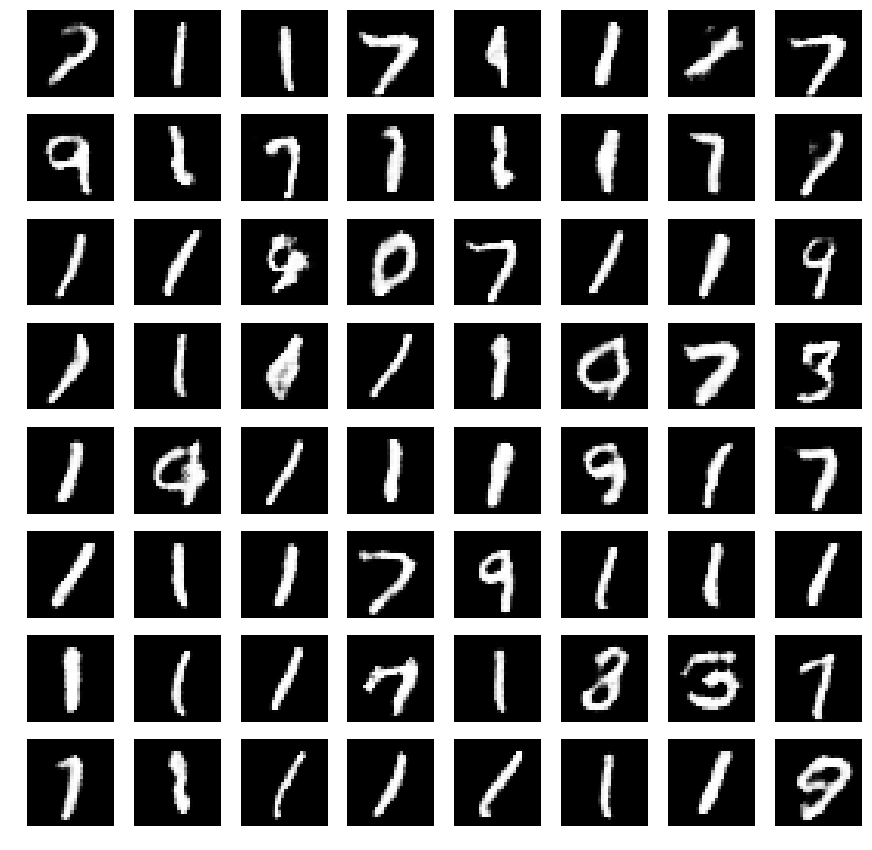

In [40]:
train_GAN(models,x_train,param)

In [41]:
#output some images generated by generator, with input as random noise
generator = load_model('gan_mnist_z.h5')
noise_input=np.random.uniform(-1.0,1.0,size=[48,dim_latent])
plot_imag(generator,noise_input,show=True,model_name='test_generator')

OSError: Unable to open file (unable to open file: name = 'gan_mnist_v3.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [47]:
generator = load_model('gan_mnist_z.h5')
noise_input=np.random.uniform(-1.0,1.0,size=[100,dim_latent])
outputs=generator.predict(noise_input)
print(outputs.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(100, 28, 28, 1)


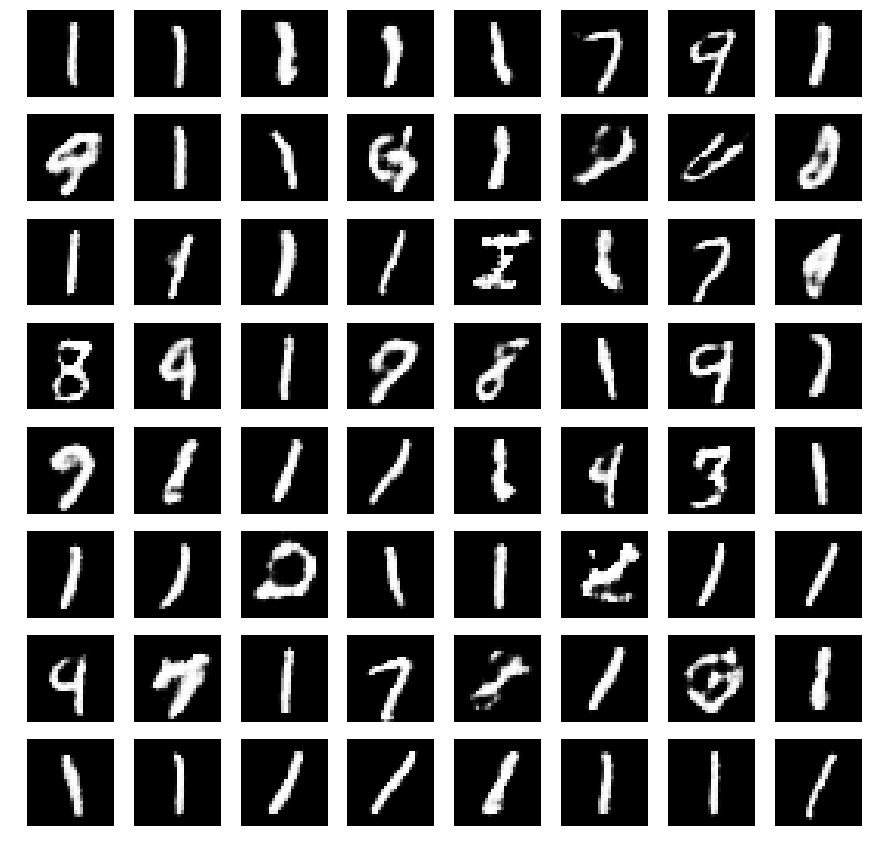

In [48]:
outputs=np.reshape(outputs,[-1,28,28])
nrow=8
ncol=8
plt.figure(figsize=(15,15))
#plt.figure(figsize=(10,15))
for i in range(nrow*ncol):
    plt.subplot(nrow,ncol,i+1)
    plt.imshow(outputs[i],cmap='gray')
    plt.axis('off')